In [201]:
import sys
print(sys.executable)
print(sys.version)

c:\ProgramData\anaconda3\python.exe
3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]


In [202]:
!{sys.executable} -m pip install unidecode

Defaulting to user installation because normal site-packages is not writeable


In [203]:
!pip install unidecode
!pip install kaggle
import pathlib
import os
import sys
from IPython.display import display
import re
from unidecode import unidecode
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [204]:
# Etape 1 – Chargement & Nettoyage

# pour lister les fichiers dans le dossier 
import os
print(os.listdir(r"D:\kaggle\archive"))

['olist_customers_dataset.csv', 'olist_geolocation_dataset.csv', 'olist_orders_dataset.csv', 'olist_order_items_dataset.csv', 'olist_order_payments_dataset.csv', 'olist_order_reviews_dataset.csv', 'olist_products_dataset.csv', 'olist_sellers_dataset.csv', 'product_category_name_translation.csv']


In [223]:
# Importer chaque fichier CSV dans un DataFrame pandas
files = {
    "orders": "olist_orders_dataset.csv",
    "order_items": "olist_order_items_dataset.csv",
    "order_reviews": "olist_order_reviews_dataset.csv",
    "order_payments": "olist_order_payments_dataset.csv",
    "customers": "olist_customers_dataset.csv",
    "products": "olist_products_dataset.csv",
    "sellers": "olist_sellers_dataset.csv",
    "geolocation": "olist_geolocation_dataset.csv",
    "product_category_name_translation": "product_category_name_translation.csv"
}

dataframes = {}
for name, fname in files.items():
    path = os.path.join(r"D:\kaggle\archive", fname)
    dataframes[name] = pd.read_csv(path)
    print(f"{name} chargé ({dataframes[name].shape[0]} lignes, {dataframes[name].shape[1]} colonnes)")

orders chargé (99441 lignes, 8 colonnes)
order_items chargé (112650 lignes, 7 colonnes)
order_reviews chargé (99224 lignes, 7 colonnes)
order_payments chargé (103886 lignes, 5 colonnes)
customers chargé (99441 lignes, 5 colonnes)
products chargé (32951 lignes, 9 colonnes)
sellers chargé (3095 lignes, 4 colonnes)
geolocation chargé (1000163 lignes, 5 colonnes)
product_category_name_translation chargé (71 lignes, 2 colonnes)


In [224]:
# Associer chaque DataFrame à ses colonnes clés
colonnes_cles = {
    "orders": ["order_id"],
    "order_items": ["order_id", "order_item_id"],
    "order_reviews": ["review_id"],
    "order_payments": ["order_id", "payment_sequential"],
    "customers": ["customer_id"],
    "products": ["product_id"],
    "sellers": ["seller_id"],
    "geolocation": ["geolocation_zip_code_prefix", "geolocation_lat", "geolocation_lng"],
    "product_category_name_translation": ["product_category_name"]
}

In [225]:
# supprimer les doublons pour chaque DataFrame sur ses colonnes clés
print("\nSuppression des doublons sur les colonnes clés :")
for name, cols in colonnes_cles.items():
    df = dataframes[name]
    avant = df.shape[0]
    df.drop_duplicates(subset=cols, inplace=True)
    apres = df.shape[0]
    print(f"{name} : {avant - apres} doublon(s) supprimé(s)")



Suppression des doublons sur les colonnes clés :
orders : 0 doublon(s) supprimé(s)
order_items : 0 doublon(s) supprimé(s)
order_reviews : 814 doublon(s) supprimé(s)
order_payments : 0 doublon(s) supprimé(s)
customers : 0 doublon(s) supprimé(s)
products : 0 doublon(s) supprimé(s)
sellers : 0 doublon(s) supprimé(s)
geolocation : 280009 doublon(s) supprimé(s)
product_category_name_translation : 0 doublon(s) supprimé(s)


In [226]:
# récupérer toutes les lignes contenant au moins une valeur manquante (null)
for name, df in dataframes.items():
    null_rows = df[df.isnull().any(axis=1)]
    print(f"{name} : {len(null_rows)} ligne(s) avec au moins une valeur manquante")

orders : 2980 ligne(s) avec au moins une valeur manquante
order_items : 0 ligne(s) avec au moins une valeur manquante
order_reviews : 88612 ligne(s) avec au moins une valeur manquante
order_payments : 0 ligne(s) avec au moins une valeur manquante
customers : 0 ligne(s) avec au moins une valeur manquante
products : 611 ligne(s) avec au moins une valeur manquante
sellers : 0 ligne(s) avec au moins une valeur manquante
geolocation : 0 ligne(s) avec au moins une valeur manquante
product_category_name_translation : 0 ligne(s) avec au moins une valeur manquante


In [227]:
# Liste des colonnes clés par fichier
colonnes_cles = {
    'orders': ['order_id', 'customer_id', 'order_purchase_timestamp', 'order_delivered_customer_date', 'order_estimated_delivery_date'],
    'order_items': ['order_id', 'order_item_id', 'product_id', 'seller_id', 'price', 'freight_value'],
    'order_reviews': ['review_id', 'order_id', 'review_score'],
    'order_payments': ['order_id', 'payment_sequential', 'payment_type', 'payment_value'],
    'customers': ['customer_id', 'customer_unique_id', 'customer_zip_code_prefix'],
    'products': ['product_id', 'product_category_name'],
    'sellers': ['seller_id', 'seller_zip_code_prefix'],
    'geolocation': ['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng'],
    'product_translation': ['product_category_name', 'product_category_name_english']
}

In [228]:
# Exemples de changements de type
dataframes['orders']['order_purchase_timestamp'] = pd.to_datetime(dataframes['orders']['order_purchase_timestamp'])
dataframes['orders']['order_delivered_customer_date'] = pd.to_datetime(dataframes['orders']['order_delivered_customer_date'])
dataframes['orders']['order_estimated_delivery_date'] = pd.to_datetime(dataframes['orders']['order_estimated_delivery_date'])

dataframes['order_items']['price'] = dataframes['order_items']['price'].astype(float)
dataframes['order_items']['freight_value'] = dataframes['order_items']['freight_value'].astype(float)

dataframes['order_payments']['payment_value'] = dataframes['order_payments']['payment_value'].astype(float)
dataframes['order_payments']['payment_sequential'] = dataframes['order_payments']['payment_sequential'].astype(int)

dataframes['geolocation']['geolocation_lat'] = dataframes['geolocation']['geolocation_lat'].astype(float)
dataframes['geolocation']['geolocation_lng'] = dataframes['geolocation']['geolocation_lng'].astype(float)

In [229]:
# pour les colonnes categorielles (optimisation de la memoire)
for col in ['product_category_name', 'payment_type']:
    if col in dataframes['products']:
        dataframes['products'][col] = dataframes['products'][col].astype('category')
    if col in dataframes['order_payments']:
        dataframes['order_payments'][col] = dataframes['order_payments'][col].astype('category')

In [231]:
def normalize_text_column(df, col):
    df[col] = df[col].astype(str).str.strip().str.lower()
    return df

# Exemple sur les colonnes textuelles principales
text_columns = {
    'products': ['product_category_name'],
    'order_payments': ['payment_type'],
    'customers': ['customer_city'],
    'sellers': ['seller_city'],
    'geolocation': [],
    'product_category_name_translation': ['product_category_name', 'product_category_name_english']
}
for df_name, cols in text_columns.items():
    if df_name not in dataframes:
        print(f"DataFrame '{df_name}' non trouvé, on passe.")
        continue
    for col in cols:
        if col in dataframes[df_name].columns:
            dataframes[df_name] = normalize_text_column(dataframes[df_name], col)

In [232]:
for df_name, cols in text_columns.items():
    if df_name not in dataframes:
        print(f"DataFrame '{df_name}' non trouvé, on passe.")
        continue  # Passe au fichier suivant si la clé n'existe pas
    for col in cols:
        if col in dataframes[df_name].columns:
            dataframes[df_name] = normalize_text_column(dataframes[df_name], col)

In [234]:
# 

# 1. Définition des colonnes par type pour chaque fichier
type_map = {
    'orders': {
        'dates': ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
                  'order_delivered_customer_date', 'order_estimated_delivery_date'],
        'ids': ['order_id', 'customer_id'],
        'numeriques': [],
        'text': ['order_status']
    },
    'order_items': {
        'dates': [],
        'ids': ['order_id', 'order_item_id', 'product_id', 'seller_id'],
        'numeriques': ['price', 'freight_value'],
        'text': []
    },
    'order_reviews': {
        'dates': ['review_creation_date', 'review_answer_timestamp'],
        'ids': ['review_id', 'order_id'],
        'numeriques': ['review_score'],
        'text': ['review_comment_title', 'review_comment_message']
    },
    'order_payments': {
        'dates': [],
        'ids': ['order_id', 'payment_sequential'],
        'numeriques': ['payment_value'],
        'text': ['payment_type']
        },
    'customers': {
        'dates': [],
        'ids': ['customer_id', 'customer_unique_id', 'customer_zip_code_prefix'],
        'numeriques': [],
        'text': ['customer_city', 'customer_state']
    },
    'products': {
        'dates': [],
        'ids': ['product_id'],
        'numeriques': [],
        'text': ['product_category_name']
    },
    'sellers': {
        'dates': [],
        'ids': ['seller_id', 'seller_zip_code_prefix'],
        'numeriques': [],
        'text': ['seller_city', 'seller_state']
    },
    'geolocation': {
        'dates': [],
        'ids': ['geolocation_zip_code_prefix'],
        'numeriques': ['geolocation_lat', 'geolocation_lng'],
        'text': ['geolocation_city', 'geolocation_state']
    },
    'product_category_name_translation': {
        'dates': [],
        'ids': [],
        'numeriques': [],
        'text': ['product_category_name', 'product_category_name_english']
    }
}

In [235]:
# 4. Classification sémantique des colonnes
semantic_keywords = {
    "Identifiant": ["id", "unique"],
    "Date": ["date", "timestamp", "datetime"],
    "Montant": ["amount", "price", "value", "payment", "freight"],
    "Catégorie": ["name", "category", "type", "state", "city", "zip", "prefix"],
    "Texte": ["comment", "message", "title", "description"],
    "Booléen": ["is_", "has_"],
}
def semantic_classification(df):
    classification = {}
    for col in df.columns:
        col_lower = col.lower()
        found = False
        for semantic_type, keywords in semantic_keywords.items():
            if any(keyword in col_lower for keyword in keywords):
                classification[col] = semantic_type
                found = True
                break
        if not found:
            if df[col].dtype == 'bool':
                classification[col] = 'Booléen'
            elif pd.api.types.is_numeric_dtype(df[col]):
                classification[col] = 'Numérique'
            elif pd.api.types.is_datetime64_any_dtype(df[col]):
                classification[col] = 'Date'
            else:
                classification[col] = 'Autre'
    return classification

print("\nClassification sémantique des colonnes :")
for name, df in dataframes.items():
    print(f"\n{name} :")
    classif = semantic_classification(df)
    for col, typ in classif.items():
        print(f"  {col} : {typ}")

# Les DataFrames nettoyés sont dans le dictionnaire `dataframes`


Classification sémantique des colonnes :

orders :
  order_id : Identifiant
  customer_id : Identifiant
  order_status : Autre
  order_purchase_timestamp : Date
  order_approved_at : Autre
  order_delivered_carrier_date : Date
  order_delivered_customer_date : Date
  order_estimated_delivery_date : Date

order_items :
  order_id : Identifiant
  order_item_id : Identifiant
  product_id : Identifiant
  seller_id : Identifiant
  shipping_limit_date : Date
  price : Montant
  freight_value : Montant

order_reviews :
  review_id : Identifiant
  order_id : Identifiant
  review_score : Numérique
  review_comment_title : Texte
  review_comment_message : Texte
  review_creation_date : Date
  review_answer_timestamp : Date

order_payments :
  order_id : Identifiant
  payment_sequential : Montant
  payment_type : Montant
  payment_installments : Montant
  payment_value : Montant

customers :
  customer_id : Identifiant
  customer_unique_id : Identifiant
  customer_zip_code_prefix : Catégorie
  c

In [236]:
# Suppression des commandes sans identifiant ou date d'achat (données incohérentes)
orders = orders.dropna(subset=['order_id', 'customer_id', 'order_purchase_timestamp'])

# Création de sous-ensembles selon le métier
orders_livrees = orders[orders['order_delivered_customer_date'].notnull()]
orders_non_livrees = orders[orders['order_delivered_customer_date'].isnull()]

print(f"Nombre de commandes livrées : {len(orders_livrees)}")
print(f"Nombre de commandes non livrées (annulées ou en attente) : {len(orders_non_livrees)}")

Nombre de commandes livrées : 96476
Nombre de commandes non livrées (annulées ou en attente) : 2965


In [237]:
# Conversion des colonnes de dates
orders['order_approved_at'] = pd.to_datetime(orders['order_approved_at'])
orders['order_delivered_carrier_date'] = pd.to_datetime(orders['order_delivered_carrier_date'])

In [238]:
#Calcul de la durée moyenne entre validation et expédition
#  Calcul de la durée (en jours) pour les lignes où les deux dates sont connues
mask_dates_connues = orders['order_approved_at'].notnull() & orders['order_delivered_carrier_date'].notnull()
duree_moyenne = (
    (orders.loc[mask_dates_connues, 'order_delivered_carrier_date'] - 
     orders.loc[mask_dates_connues, 'order_approved_at']).dt.days.mean()
)
print(f"Durée moyenne entre validation et expédition : {duree_moyenne:.2f} jours")

Durée moyenne entre validation et expédition : 2.30 jours


In [239]:
# Etape 2 – Transformation des données

# 4. Calcule la durée de livraison pour chaque commande : order_delivered_customer_date - order_purchase_timestamp
# Conversion des dates au bon format
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])

In [240]:
# Calcul de la durée de livraison (en jours)
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['delivery_time_days'] = (orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']).dt.days

In [241]:
# pour afficher les 10 premières lignes avec la durée de livraison
print(orders[['order_id', 'order_purchase_timestamp', 'order_delivered_customer_date', 'delivery_time_days']].head(10))

                           order_id order_purchase_timestamp  \
0  e481f51cbdc54678b7cc49136f2d6af7      2017-10-02 10:56:33   
1  53cdb2fc8bc7dce0b6741e2150273451      2018-07-24 20:41:37   
2  47770eb9100c2d0c44946d9cf07ec65d      2018-08-08 08:38:49   
3  949d5b44dbf5de918fe9c16f97b45f8a      2017-11-18 19:28:06   
4  ad21c59c0840e6cb83a9ceb5573f8159      2018-02-13 21:18:39   
5  a4591c265e18cb1dcee52889e2d8acc3      2017-07-09 21:57:05   
6  136cce7faa42fdb2cefd53fdc79a6098      2017-04-11 12:22:08   
7  6514b8ad8028c9f2cc2374ded245783f      2017-05-16 13:10:30   
8  76c6e866289321a7c93b82b54852dc33      2017-01-23 18:29:09   
9  e69bfb5eb88e0ed6a785585b27e16dbf      2017-07-29 11:55:02   

  order_delivered_customer_date  delivery_time_days  
0           2017-10-10 21:25:13                 8.0  
1           2018-08-07 15:27:45                13.0  
2           2018-08-17 18:06:29                 9.0  
3           2017-12-02 00:28:42                13.0  
4           2018-02-16 18

In [242]:
# pour afficher les commandes avec une durée de livraison manquante (non livrées)
print(orders[orders['delivery_time_days'].isnull()][['order_id', 'order_status']].head(10))

                             order_id order_status
6    136cce7faa42fdb2cefd53fdc79a6098     invoiced
44   ee64d42b8cf066f35eac1cf57de1aa85      shipped
103  0760a852e4e9d89eb77bf631eaaf1c84     invoiced
128  15bed8e2fec7fdbadb186b57c46c92f2   processing
154  6942b8da583c2f9957e990d028607019      shipped
162  36530871a5e80138db53bcfd8a104d90      shipped
231  4d630f57194f5aba1a3d12ce23e71cd9      shipped
266  8e24261a7e58791d10cb1bf9da94df5c  unavailable
299  3b4ad687e7e5190db827e1ae5a8989dd      shipped
305  b68d69564a79dea4776afa33d1d2fcab      shipped


In [243]:
# Statistiques sur la durée de livraison
print("Statistiques sur la durée de livraison (en jours) :")
print(orders['delivery_time_days'].describe())

Statistiques sur la durée de livraison (en jours) :
count    96476.000000
mean        12.094086
std          9.551746
min          0.000000
25%          6.000000
50%         10.000000
75%         15.000000
max        209.000000
Name: delivery_time_days, dtype: float64


In [244]:
# 5. Calcule l’écart entre la date estimée et la date réelle de livraison. Crée une variable binaire on_time_delivery qui vaut True si la commande a été livrée à temps ou en avance.
# on s'assure que les colonnes sont bien au format datetime
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])

In [245]:
# Calcule l’écart (en jours) entre la date réelle et la date estimée de livraison
orders['delivery_delay_days'] = (orders['order_delivered_customer_date'] - orders['order_estimated_delivery_date']).dt.days

In [246]:
# Crée la variable binaire on_time_delivery
orders['on_time_delivery'] = orders['delivery_delay_days'] <= 0

In [ ]:
# Afficher le résultat pour vérification
print(orders[['order_id', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'delivery_delay_days', 'on_time_delivery']].head(10))

                           order_id order_delivered_customer_date  \
0  e481f51cbdc54678b7cc49136f2d6af7           2017-10-10 21:25:13   
1  53cdb2fc8bc7dce0b6741e2150273451           2018-08-07 15:27:45   
2  47770eb9100c2d0c44946d9cf07ec65d           2018-08-17 18:06:29   
3  949d5b44dbf5de918fe9c16f97b45f8a           2017-12-02 00:28:42   
4  ad21c59c0840e6cb83a9ceb5573f8159           2018-02-16 18:17:02   
5  a4591c265e18cb1dcee52889e2d8acc3           2017-07-26 10:57:55   
6  136cce7faa42fdb2cefd53fdc79a6098                           NaT   
7  6514b8ad8028c9f2cc2374ded245783f           2017-05-26 12:55:51   
8  76c6e866289321a7c93b82b54852dc33           2017-02-02 14:08:10   
9  e69bfb5eb88e0ed6a785585b27e16dbf           2017-08-16 17:14:30   

  order_estimated_delivery_date  delivery_delay_days  on_time_delivery  
0                    2017-10-18                 -8.0              True  
1                    2018-08-13                 -6.0              True  
2                    

In [247]:
# 6. Calcule le montant total payé par commande (en fusionnant les paiements et les items).

data_path = r'D:\kaggle\archive'  # Mets ici le chemin où sont tes fichiers

dfs = {
    'orders': pd.read_csv(f'{data_path}/olist_orders_dataset.csv'),
    'order_items': pd.read_csv(f'{data_path}/olist_order_items_dataset.csv'),
    'order_reviews': pd.read_csv(f'{data_path}/olist_order_reviews_dataset.csv'),
    'order_payments': pd.read_csv(f'{data_path}/olist_order_payments_dataset.csv'),
    'customers': pd.read_csv(f'{data_path}/olist_customers_dataset.csv')
}
# 1. Calcul du montant total payé par commande
# 6. Montant total payé par commande
order_payments = dfs['order_payments']
total_paid_per_order = order_payments.groupby('order_id')['payment_value'].sum().reset_index()
total_paid_per_order.rename(columns={'payment_value': 'total_paid'}, inplace=True)

# 2. Fusion avec la table orders
orders = dfs['orders'].merge(total_paid_per_order, on='order_id', how='left')

# 3. Afficher le nombre total de commandes avec un montant payé renseigné
print(f"Nombre de commandes avec montant payé : {orders['total_paid'].notnull().sum()}")

# Ce résultat nous donne, pour chaque commande, le montant total payé (tous moyens de paiement confondus).


Nombre de commandes avec montant payé : 99440


In [248]:
# Calcule le frais de port moyen par commande.
freight_per_order = order_items.groupby('order_id')['freight_value'].mean().reset_index()
freight_per_order.rename(columns={'freight_value': 'mean_freight'}, inplace=True)
orders = orders.merge(freight_per_order, on='order_id', how='left')
print(orders['mean_freight'].notnull().sum())

98666


In [249]:
# 8. Crée une table finale contenant, pour chaque commande : ID client, Date de commande, Délai de livraison, Estimation vs réel, Score de satisfaction (review_score), Livraison à l’heure (oui/non)

# Conversion des dates
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])

# Calcul des colonnes demandées
orders['delivery_time_days'] = (orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']).dt.days
orders['delivery_delay_days'] = (orders['order_delivered_customer_date'] - orders['order_estimated_delivery_date']).dt.days
orders['on_time_delivery'] = orders['delivery_delay_days'] <= 0

# Calcul du total payé
total_paid_per_order = order_payments.groupby('order_id')['payment_value'].sum().reset_index()
total_paid_per_order.rename(columns={'payment_value': 'total_paid'}, inplace=True)
orders = orders.merge(total_paid_per_order, on='order_id', how='left')

# Vérifions que ces colonnes existent bien dans orders
print(orders.columns)

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'total_paid_x', 'mean_freight', 'delivery_time_days',
       'delivery_delay_days', 'on_time_delivery', 'total_paid_y'],
      dtype='object')


In [250]:
print(final_table.columns)

Index(['order_id', 'customer_id', 'order_purchase_timestamp',
       'delivery_time_days', 'delivery_delay_days', 'review_score',
       'total_paid', 'on_time_delivery', 'customer_zip_code_prefix'],
      dtype='object')


In [251]:
# Vérifie le contenu de total_paid_per_order
print(total_paid_per_order.head())

                           order_id  total_paid
0  00010242fe8c5a6d1ba2dd792cb16214       72.19
1  00018f77f2f0320c557190d7a144bdd3      259.83
2  000229ec398224ef6ca0657da4fc703e      216.87
3  00024acbcdf0a6daa1e931b038114c75       25.78
4  00042b26cf59d7ce69dfabb4e55b4fd9      218.04


In [252]:
# Fusionne AVANT la fusion avec les reviews
orders = orders.merge(total_paid_per_order, on='order_id', how='left')
print(orders.columns)  # Vérifie que 'total_paid' est bien là

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'total_paid_x', 'mean_freight', 'delivery_time_days',
       'delivery_delay_days', 'on_time_delivery', 'total_paid_y',
       'total_paid'],
      dtype='object')


In [253]:
# fusionnons avec les scores de satisfaction
review_scores = order_reviews.groupby('order_id')['review_score'].mean().reset_index()
final_table = orders.merge(review_scores, on='order_id', how='left')
print(final_table.columns)  # Vérifie que 'total_paid' est toujours là

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'total_paid_x', 'mean_freight', 'delivery_time_days',
       'delivery_delay_days', 'on_time_delivery', 'total_paid_y', 'total_paid',
       'review_score'],
      dtype='object')


In [255]:
# 4. Sélectionner les colonnes demandées
final_table = final_table[[
    'order_id',
    'customer_id',
    'order_purchase_timestamp',
    'delivery_time_days',
    'delivery_delay_days',
    'review_score',
    'total_paid',
    'on_time_delivery'
]]
print(final_table.head())

                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_purchase_timestamp  delivery_time_days  delivery_delay_days  \
0      2017-10-02 10:56:33                 8.0                 -8.0   
1      2018-07-24 20:41:37                13.0                 -6.0   
2      2018-08-08 08:38:49                 9.0                -18.0   
3      2017-11-18 19:28:06                13.0                -13.0   
4      2018-02-13 21:18:39                 2.0                -10.0   

   review_score  total_paid  on_time_delivery  
0           4.0       38.71              True  
1           4.0      141.46           

In [256]:
# 9.Intègre les données clients pour ajouter le code postal à la table finale.

# Prépare la table des clients. "Le code postal se trouve dans la colonne customer_zip_code_prefix de la table customers."
# On ne garde que les colonnes utiles pour la fusion
customers_zip = customers[['customer_id', 'customer_zip_code_prefix']]

# Fusionne avec la table finale. On fusionne sur la colonne customer_id pour ajouter le code postal à chaque commande 
final_table = final_table.merge(customers_zip, on='customer_id', how='left')

# verifions le resultat
print(final_table[['order_id', 'customer_id', 'customer_zip_code_prefix']].head())

                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

   customer_zip_code_prefix  
0                      3149  
1                     47813  
2                     75265  
3                     59296  
4                      9195  


In [258]:
# Etape 4 – Analyse exploratoire
# 10. Quelle est la répartition des scores de satisfaction (1 à 5) ?

# Affiche le nombre de commandes pour chaque score de satisfaction (1 à 5). comptage des scores
print(final_table['review_score'].value_counts().sort_index())

review_score
1.000000    11316
1.500000        8
2.000000     3125
2.500000       34
3.000000     8136
3.333333        1
3.500000       25
4.000000    19018
4.333333        1
4.500000       54
5.000000    56955
Name: count, dtype: int64


In [259]:
# Affiche la répartition en pourcentage
print(final_table['review_score'].value_counts(normalize=True).sort_index() * 100)

review_score
1.000000    11.468183
1.500000     0.008108
2.000000     3.167026
2.500000     0.034457
3.000000     8.245417
3.333333     0.001013
3.500000     0.025336
4.000000    19.273763
4.333333     0.001013
4.500000     0.054726
5.000000    57.720957
Name: proportion, dtype: float64


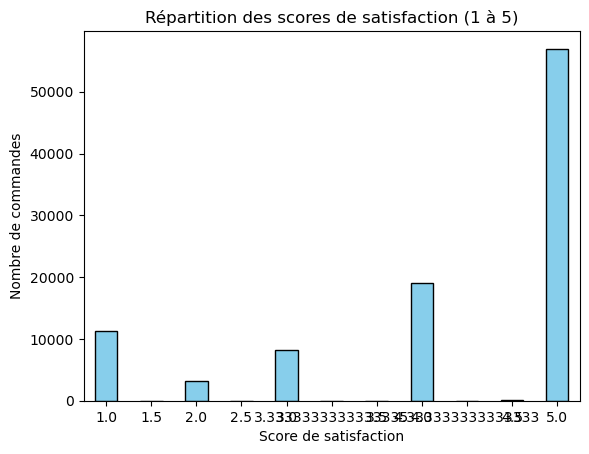

In [261]:
# Visualisation graphique (optionnel)
final_table['review_score'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Répartition des scores de satisfaction (1 à 5)")
plt.xlabel("Score de satisfaction")
plt.ylabel("Nombre de commandes")
plt.xticks(rotation=0)
plt.show()

In [262]:
# 11.  Le délai de livraison a-t-il un impact sur la satisfaction ? Affiche la moyenne de review_score selon que la commande a été livrée à temps ou non.

# Affiche la moyenne de review_score ou du score de satisfaction selon la ponctualité de la livraison
print(final_table.groupby('on_time_delivery')['review_score'].mean())

on_time_delivery
False    2.112087
True     4.290450
Name: review_score, dtype: float64


In [263]:
result = final_table.groupby('on_time_delivery')['review_score'].mean().reset_index()
result['on_time_delivery'] = result['on_time_delivery'].map({True: 'Livrée à temps', False: 'Livrée en retard'})
print(result)  # pour plus de lisibilité

   on_time_delivery  review_score
0  Livrée en retard      2.112087
1    Livrée à temps      4.290450


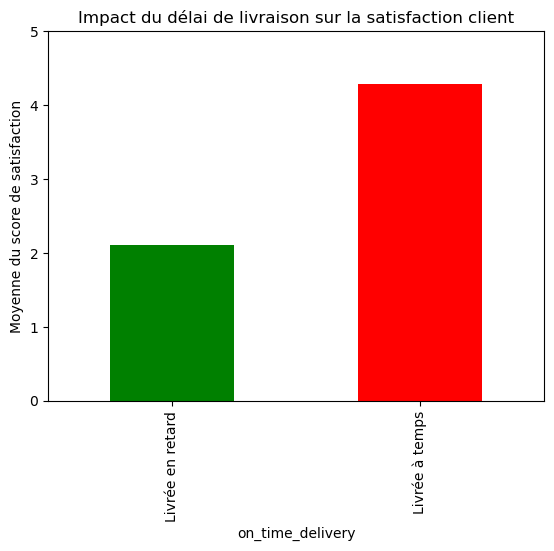

In [264]:
# Visualisation graphique (optionnel)
result.set_index('on_time_delivery')['review_score'].plot(kind='bar', color=['green', 'red'])
plt.ylabel("Moyenne du score de satisfaction")
plt.title("Impact du délai de livraison sur la satisfaction client")
plt.ylim(0, 5)
plt.show()

In [267]:
# Statistiques de la durée de livraison pour chaque score de satisfaction
stats = final_table.groupby('review_score')['delivery_time_days'].describe()
print(stats)

                count       mean        std   min   25%   50%    75%    max
review_score                                                               
1.000000       9316.0  20.877845  16.092350   0.0   9.0  16.0  30.00  195.0
1.500000          8.0  17.000000  16.604647   4.0  10.0  11.5  16.00   57.0
2.000000       2916.0  16.197874  12.454939   1.0   8.0  13.0  22.00  208.0
2.500000         30.0  18.266667  14.146849   2.0  10.0  14.5  19.75   67.0
3.000000       7916.0  13.779308   9.918642   0.0   7.0  12.0  18.00  188.0
3.333333          1.0  22.000000        NaN  22.0  22.0  22.0  22.00   22.0
3.500000         23.0  12.913043   7.178966   5.0   8.0  12.0  16.50   27.0
4.000000      18868.0  11.842432   8.303731   0.0   7.0  10.0  15.00  194.0
4.333333          1.0   3.000000        NaN   3.0   3.0   3.0   3.00    3.0
4.500000         53.0  12.301887   5.819678   4.0   7.0  12.0  16.00   24.0
5.000000      56698.0  10.213888   6.823120   0.0   6.0   9.0  13.00  187.0


<Figure size 1000x600 with 0 Axes>

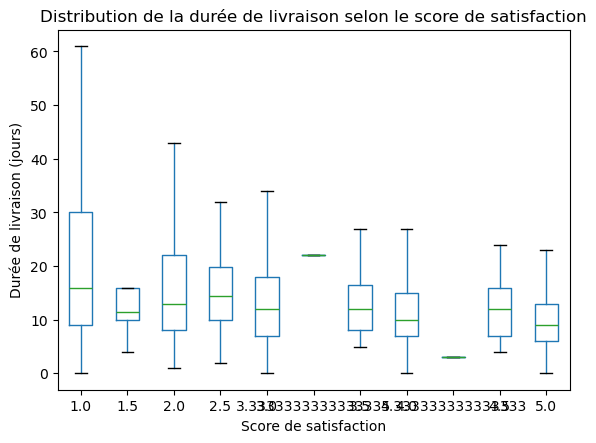

In [271]:
# Visualisation graphique. a) Boxplot (très parlant)
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
final_table.boxplot(column='delivery_time_days', by='review_score', grid=False, showfliers=False)
plt.title("Distribution de la durée de livraison selon le score de satisfaction")
plt.suptitle('')
plt.xlabel("Score de satisfaction")
plt.ylabel("Durée de livraison (jours)")
plt.show()

C:\Users\Mon PC\AppData\Local\Temp\ipykernel_16996\332337720.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='review_score', y='delivery_time_days', data=final_table, palette='pastel', cut=0)


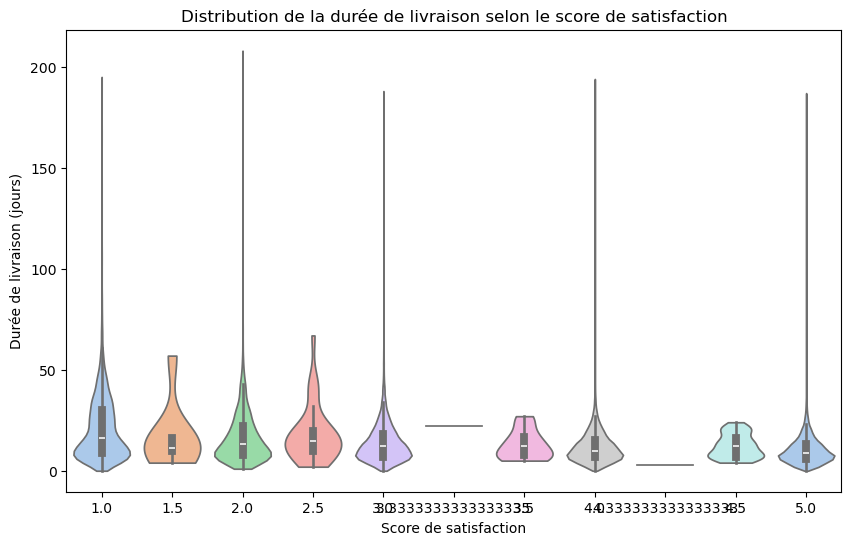

In [272]:
# b) Violin plot (si tu veux une visualisation plus fine)
import seaborn as sns

plt.figure(figsize=(10,6))
sns.violinplot(x='review_score', y='delivery_time_days', data=final_table, palette='pastel', cut=0)
plt.title("Distribution de la durée de livraison selon le score de satisfaction")
plt.xlabel("Score de satisfaction")
plt.ylabel("Durée de livraison (jours)")
plt.show()

In [273]:
# 12. Quel est le montant moyen des commandes selon le score de satisfaction ?
# Calcul du montant moyen par score de satisfaction. calcul effectué avec pandas
mean_amount_by_score = final_table.groupby('review_score')['total_paid'].mean().sort_index()
print(mean_amount_by_score)

review_score
1.000000    195.811465
1.500000    204.703750
2.000000    172.962858
2.500000    132.053235
3.000000    151.647585
3.333333     42.110000
3.500000    143.645600
4.000000    154.868719
4.333333     42.770000
4.500000    121.889815
5.000000    156.395515
Name: total_paid, dtype: float64


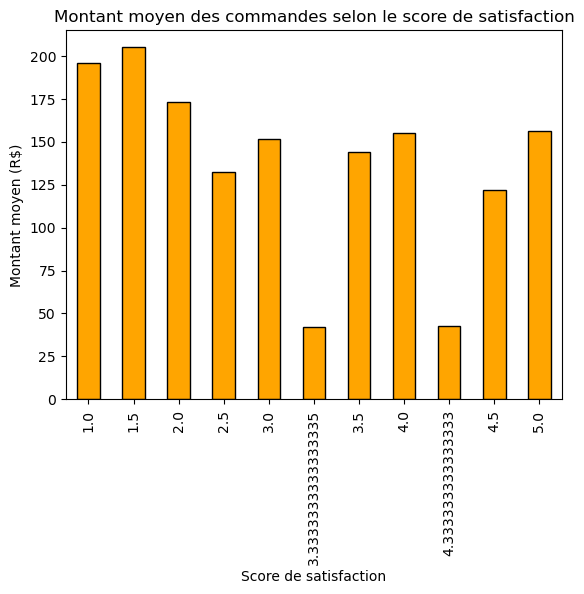

In [274]:
# Visualisation rapide (optionnel)
import matplotlib.pyplot as plt

mean_amount_by_score.plot(kind='bar', color='orange', edgecolor='black')
plt.title("Montant moyen des commandes selon le score de satisfaction")
plt.xlabel("Score de satisfaction")
plt.ylabel("Montant moyen (R$)")
plt.show()

In [275]:
# 11. Le délai de livraison a-t-il un impact sur la satisfaction ? Affiche la moyenne de review_score selon que la commande a été livrée à temps ou non.

# Calcul de la moyenne du score selon la ponctualité
result = final_table.groupby('on_time_delivery')['review_score'].mean().reset_index()
result['on_time_delivery'] = result['on_time_delivery'].map({True: 'Livrée à temps', False: 'Livrée en retard'})
print(result)

   on_time_delivery  review_score
0  Livrée en retard      2.112087
1    Livrée à temps      4.290450


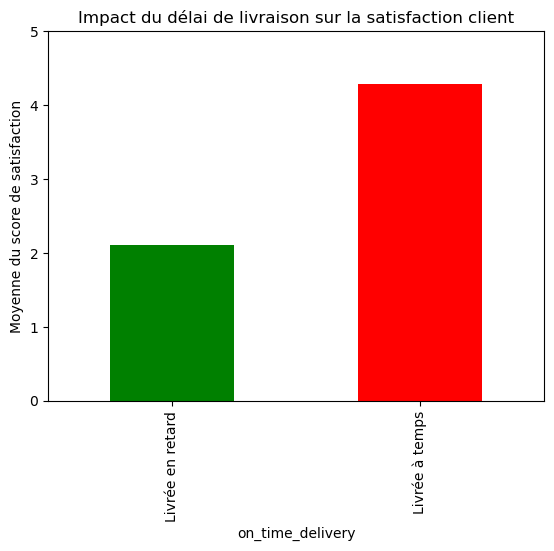

In [276]:
import matplotlib.pyplot as plt

result.set_index('on_time_delivery')['review_score'].plot(kind='bar', color=['green', 'red'])
plt.ylabel("Moyenne du score de satisfaction")
plt.title("Impact du délai de livraison sur la satisfaction client")
plt.ylim(0, 5)
plt.show()

In [277]:
# 13.Quelles sont les 5 villes avec le plus de commandes livrées en retard ?

# 1. Sélection des commandes livrées en retard
late_orders = final_table[final_table['on_time_delivery'] == False]

# 2. Fusion avec la table clients pour récupérer la ville
late_orders = late_orders.merge(customers[['customer_id', 'customer_city']], on='customer_id', how='left')

# 3. Comptage et affichage du top 5
top5_cities = late_orders['customer_city'].value_counts().head(5)
print(top5_cities)

customer_city
sao paulo         1209
rio de janeiro     984
salvador           231
belo horizonte     213
brasilia           178
Name: count, dtype: int64


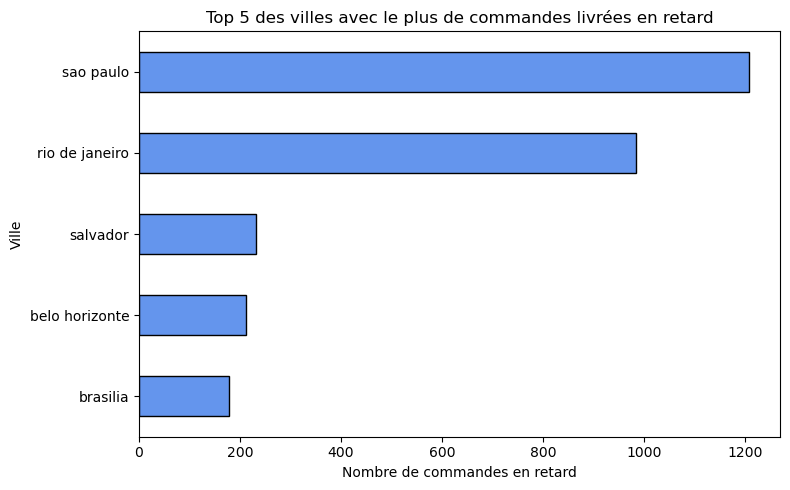

In [278]:
import matplotlib.pyplot as plt

# Supposons que top5_cities est déjà calculé comme suit :
# top5_cities = late_orders['customer_city'].value_counts().head(5)

plt.figure(figsize=(8,5))
top5_cities.sort_values().plot(kind='barh', color='cornflowerblue', edgecolor='black')
plt.xlabel("Nombre de commandes en retard")
plt.ylabel("Ville")
plt.title("Top 5 des villes avec le plus de commandes livrées en retard")
plt.tight_layout()
plt.show()

In [279]:
# 14.Quels sont les produits qui génèrent le plus de retards ?

late_items = late_orders.merge(order_items[['order_id', 'product_id']], on='order_id', how='left')
late_items = late_items.merge(products[['product_id', 'product_category_name']], on='product_id', how='left')
top_categories = late_items['product_category_name'].value_counts().head(10)
print(top_categories)

product_category_name
cama_mesa_banho           932
beleza_saude              920
moveis_decoracao          748
esporte_lazer             742
informatica_acessorios    680
relogios_presentes        556
utilidades_domesticas     509
telefonia                 423
automotivo                387
ferramentas_jardim        359
Name: count, dtype: int64


In [280]:
# 14.Quels sont les produits qui génèrent le plus de retards ?

# 1. Sélection des commandes livrées en retard
late_orders = orders[orders['on_time_delivery'] == False][['order_id']]

# 2. Association aux produits
late_items = late_orders.merge(order_items[['order_id', 'product_id']], on='order_id', how='left')

# 3. Chargement des catégories produits
products = pd.read_csv(r'D:\kaggle\archive\olist_products_dataset.csv')[['product_id', 'product_category_name']]

# 4. Fusion pour récupérer la catégorie
late_items = late_items.merge(products, on='product_id', how='left')

# 5. Comptage des retards par catégorie
top_categories = late_items['product_category_name'].value_counts().head(10)
print("Top 10 des catégories de produits générant le plus de retards :")
print(top_categories)

Top 10 des catégories de produits générant le plus de retards :
product_category_name
cama_mesa_banho           932
beleza_saude              920
moveis_decoracao          748
esporte_lazer             742
informatica_acessorios    680
relogios_presentes        556
utilidades_domesticas     509
telefonia                 423
automotivo                387
ferramentas_jardim        359
Name: count, dtype: int64


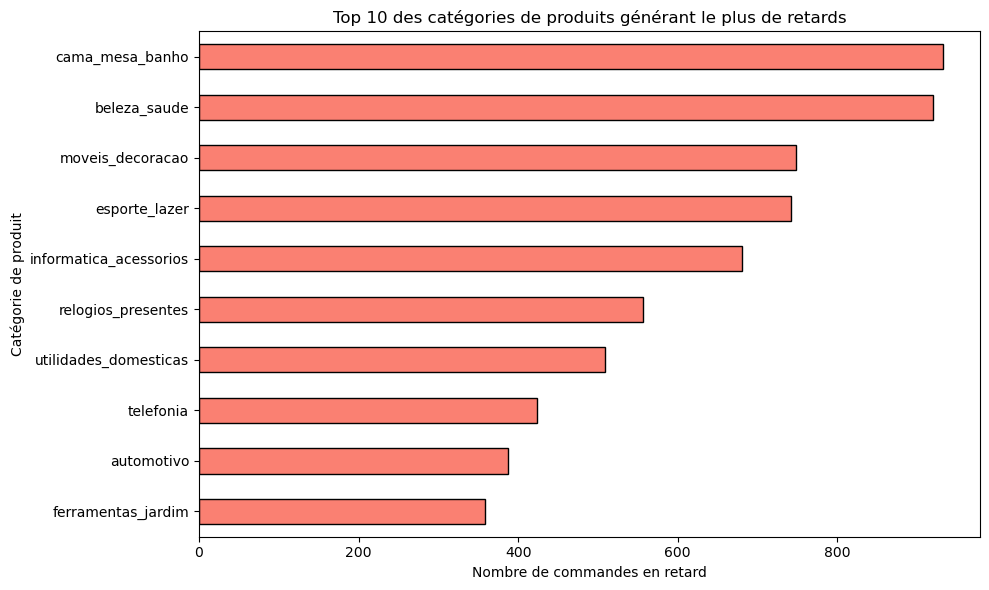

In [281]:
import matplotlib.pyplot as plt

# Supposons que top_categories est déjà calculé comme suit :
# top_categories = late_items['product_category_name'].value_counts().head(10)

plt.figure(figsize=(10,6))
top_categories.sort_values().plot(kind='barh', color='salmon', edgecolor='black')
plt.xlabel("Nombre de commandes en retard")
plt.ylabel("Catégorie de produit")
plt.title("Top 10 des catégories de produits générant le plus de retards")
plt.tight_layout()
plt.show()

In [282]:
# liste des categorie des produit commandés plus de details
# on fusion les commandes, items et catégories pour rattacher chaque commande à sa catégorie produit
order_items_products = order_items.merge(products[['product_id', 'product_category_name']], on='product_id', how='left')

# calcul des Statistiques par catégorie de produits
category_stats = order_items_products.groupby('product_category_name').agg(
    nb_commandes=('order_id', 'nunique'),
    nb_produits=('product_id', 'count'),
    montant_total=('price', 'sum'),
    montant_moyen=('price', 'mean'),
    frais_port_total=('freight_value', 'sum'),
    frais_port_moyen=('freight_value', 'mean')
).sort_values('nb_commandes', ascending=False)

print(category_stats.head(20))  # on affiche la liste detaillée des 20 catégories les plus commandée

                             nb_commandes  nb_produits  montant_total  \
product_category_name                                                   
cama_mesa_banho                      9417        11115     1036988.68   
beleza_saude                         8836         9670     1258681.34   
esporte_lazer                        7720         8641      988048.97   
informatica_acessorios               6689         7827      911954.32   
moveis_decoracao                     6449         8334      729762.49   
utilidades_domesticas                5884         6964      632248.66   
relogios_presentes                   5624         5991     1205005.68   
telefonia                            4199         4545      323667.53   
automotivo                           3897         4235      592720.11   
brinquedos                           3886         4117      483946.60   
cool_stuff                           3632         3796      635290.85   
ferramentas_jardim                   3518         4

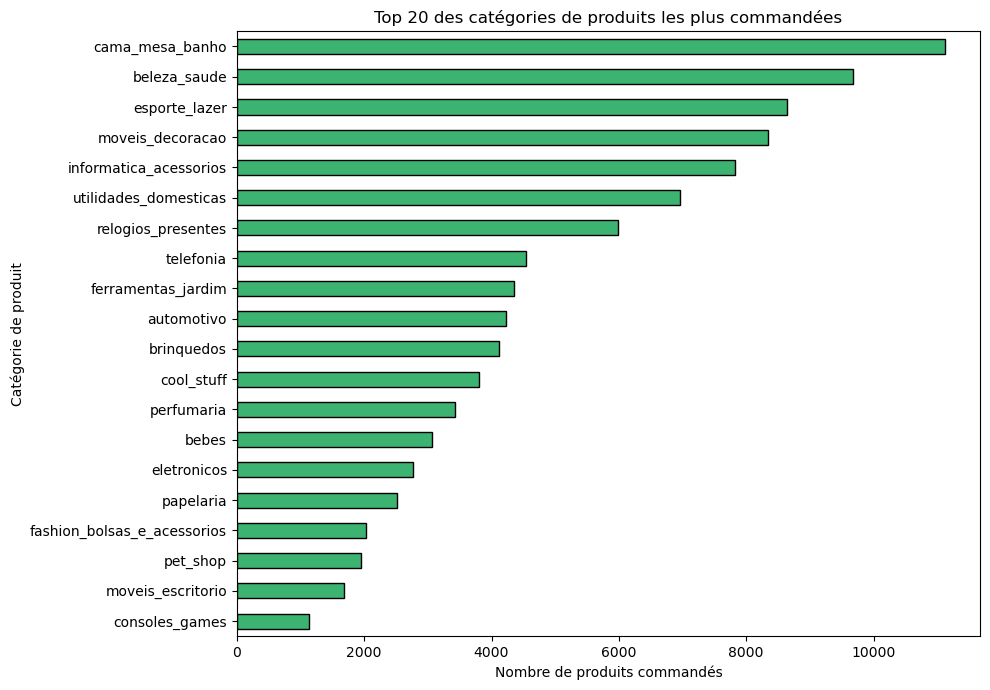

In [283]:
import matplotlib.pyplot as plt

# Supposons que top_categories est déjà calculé comme suit :
top_categories = late_items['product_category_name'].value_counts().head(20)

# On suppose que ordered_products est déjà créé par fusion entre order_items et products
cat_counts = ordered_products['product_category_name'].value_counts().head(20)

plt.figure(figsize=(10,7))
cat_counts.sort_values().plot(kind='barh', color='mediumseagreen', edgecolor='black')
plt.xlabel("Nombre de produits commandés")
plt.ylabel("Catégorie de produit")
plt.title("Top 20 des catégories de produits les plus commandées")
plt.tight_layout()
plt.show()

In [284]:
# le top par product_id au lieu de la catégorie
top_products = late_items['product_id'].value_counts().head(10)
print(top_products)

product_id
aca2eb7d00ea1a7b8ebd4e68314663af    49
422879e10f46682990de24d770e7f83d    47
3fbc0ef745950c7932d5f2a446189725    40
99a4788cb24856965c36a24e339b6058    40
389d119b48cf3043d311335e499d9c6b    32
19c91ef95d509ea33eda93495c4d3481    30
368c6c730842d78016ad823897a372db    29
53759a2ecddad2bb87a079a1f1519f73    29
bb50f2e236e5eea0100680137654686c    29
d1c427060a0f73f6b889a5c7c61f2ac4    28
Name: count, dtype: int64


In [287]:
# 15.Quel est le nombre moyen de jours de retard par catégorie de produit (product_category_name) ?

late_items = late_items.merge(final_table[['order_id', 'delivery_delay_days']], on='order_id', how='left')
mean_delay_by_category = late_items.groupby('product_category_name')['delivery_delay_days'].mean().sort_values(ascending=False)
print(mean_delay_by_category.head(10))

product_category_name
eletrodomesticos_2           21.928571
alimentos_bebidas            18.454545
musica                       18.000000
moveis_colchao_e_estofado    15.200000
sinalizacao_e_seguranca      14.750000
casa_conforto_2              14.500000
climatizacao                 14.363636
bebidas                      14.125000
casa_conforto                12.975000
alimentos                    12.628571
Name: delivery_delay_days, dtype: float64


In [288]:
# On suppose que late_items contient : order_id, product_id, product_category_name, et delivery_delay_days
# Si ce n'est pas déjà fait, fusionne les retards avec les catégories :
late_orders = orders[orders['delivery_delay_days'] > 0][['order_id', 'delivery_delay_days']]
late_items = order_items.merge(late_orders, on='order_id', how='inner')
late_items = late_items.merge(products[['product_id', 'product_category_name']], on='product_id', how='left')

# Calcul du nombre moyen de jours de retard par catégorie de produit
mean_delay_by_category = late_items.groupby('product_category_name')['delivery_delay_days'].mean().sort_values(ascending=False)

print(mean_delay_by_category)

product_category_name
eletrodomesticos_2                               21.928571
alimentos_bebidas                                18.454545
musica                                           18.000000
moveis_colchao_e_estofado                        15.200000
sinalizacao_e_seguranca                          14.750000
                                                   ...    
fashion_roupa_feminina                            3.333333
construcao_ferramentas_jardim                     3.307692
artes                                             3.166667
portateis_cozinha_e_preparadores_de_alimentos     3.000000
cine_foto                                         3.000000
Name: delivery_delay_days, Length: 66, dtype: float64


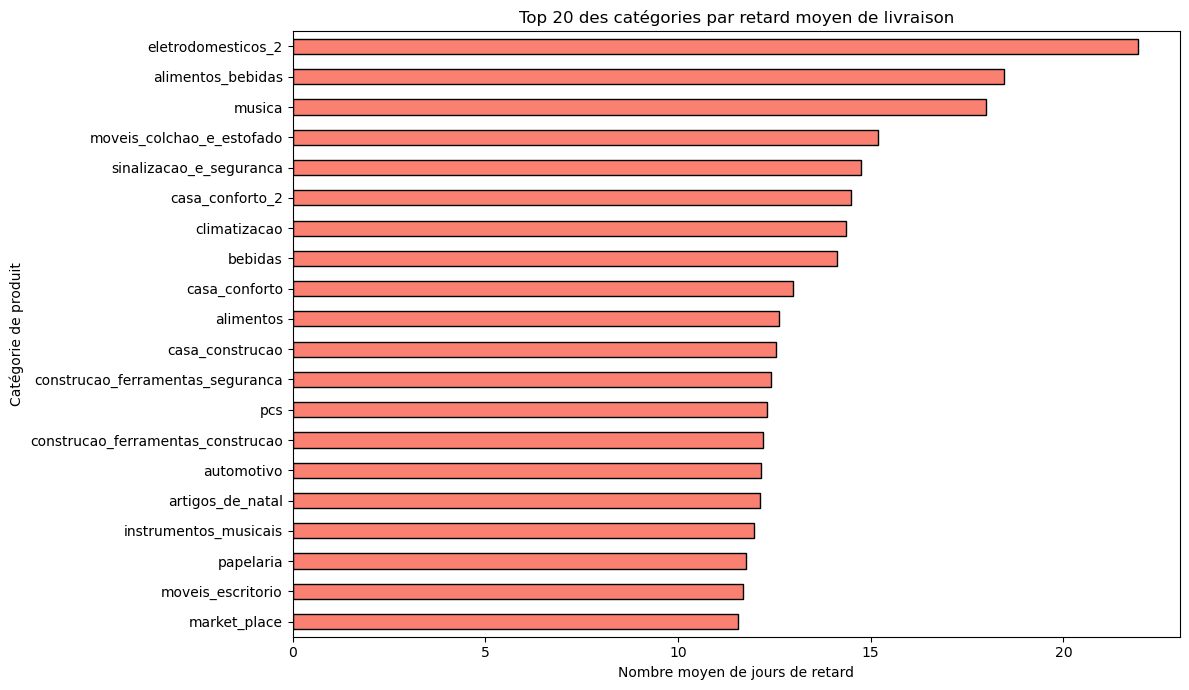

In [291]:
import matplotlib.pyplot as plt

# Supposons que 'mean_delay_by_category' est déjà calculé comme suit :
# mean_delay_by_category = late_items.groupby('product_category_name')['delivery_delay_days'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 7))
mean_delay_by_category.head(20).sort_values().plot(kind='barh', color='salmon', edgecolor='black')
plt.xlabel("Nombre moyen de jours de retard")
plt.ylabel("Catégorie de produit")
plt.title("Top 20 des catégories par retard moyen de livraison")
plt.tight_layout()
plt.show()

In [292]:
mean_delay_by_category = late_items.groupby('product_category_name')['delivery_delay_days'].mean().sort_values(ascending=False)

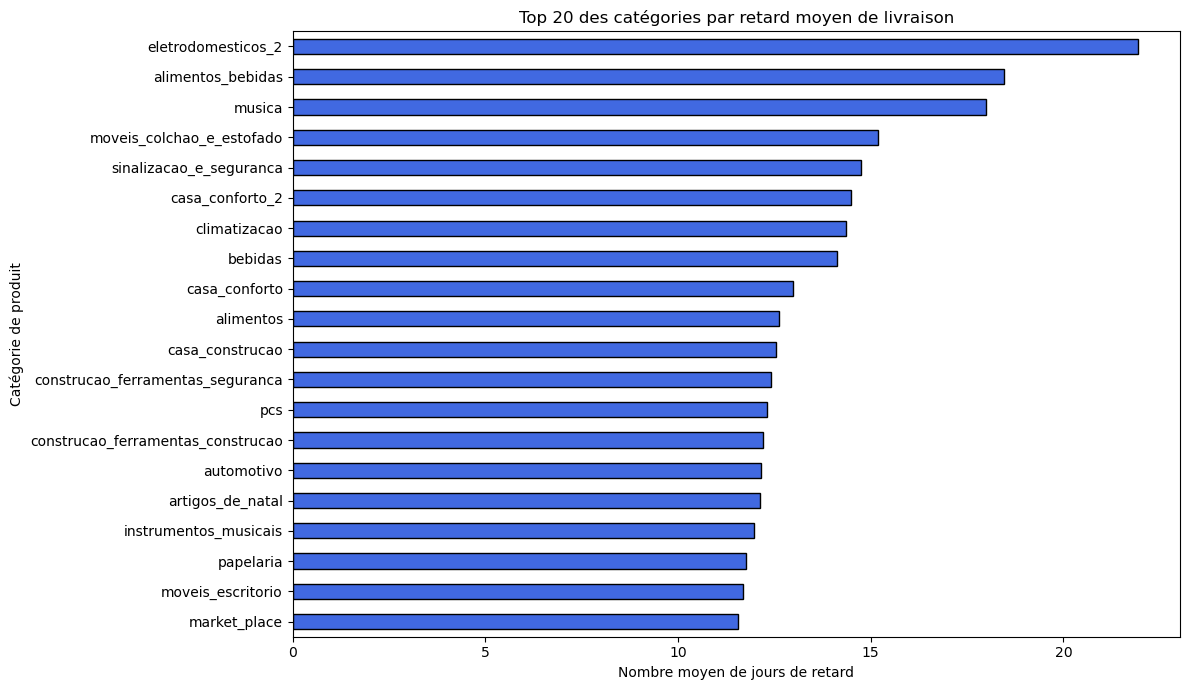

In [294]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))
mean_delay_by_category.head(20).sort_values().plot(
    kind='barh',
    color='royalblue',
    edgecolor='black'
)
plt.xlabel("Nombre moyen de jours de retard")
plt.ylabel("Catégorie de produit")
plt.title("Top 20 des catégories par retard moyen de livraison")
plt.tight_layout()
plt.show()

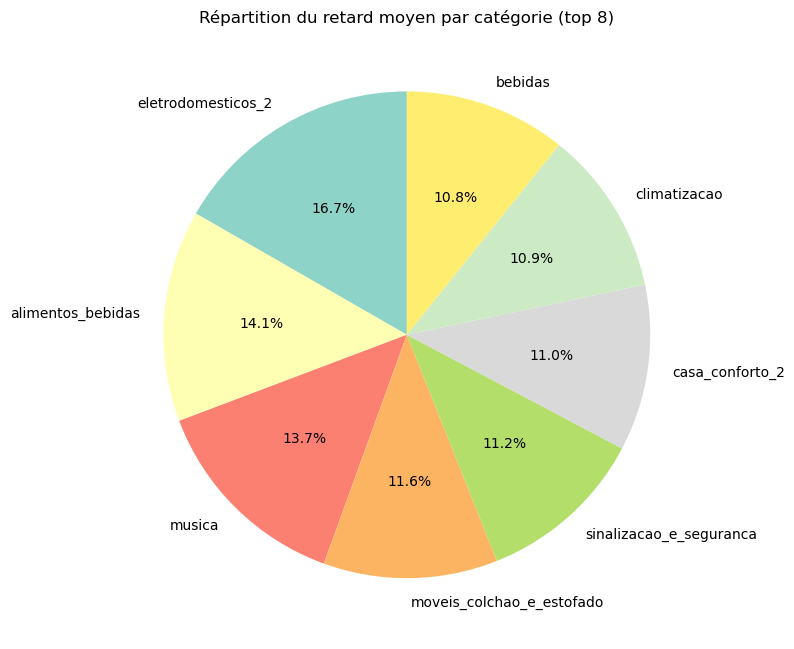

In [295]:
plt.figure(figsize=(8, 8))
mean_delay_by_category.head(8).plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90,
    colormap='Set3'
)
plt.ylabel('')
plt.title("Répartition du retard moyen par catégorie (top 8)")
plt.tight_layout()
plt.show()